# Predicting Heart Disease In Hungary (Group 73)

## Part 1: Introduction

Heart disease is a broad term that refers to different heart conditions. Something in common is their effect on blood flow and dilation of veins to the heart. Other factors such as age, cholesterol, and blood pressure are also closely linked with heart disease.  

Our project aims to predict whether a person is at risk of a heart disease given some data that can be collected through medical tests. The factors we use to predict are:
1. Age [age]
2. Resting blood pressure (in mm Hg on admission to the hospital) [trestbps]
3. Cholesterol [chol]
4. Maximum heart rate achieved [thalach]

The data was taken from the UCI Machine Learning Repository's Heart Disease Dataset and was used to train our model to predict whether someone has heart disease based on the 4 risk factors listed above. Our model will diagnose heart disease based on the percentage of narrowing in major arteries (<50% meaning that the patient does NOT have heart disease and >50% meaning that the patient DOES have heart disease).

The directory was retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. There are four databases: Cleveland, Hungary, Long Beach (California), and Switzerland. The Hungarian data was chosen due to its binary column indicating whether a person is likely to have heart disease. The dataset was collected from the Hungarian Institute of Cardiology in Budapest.

## Part 2: Methods & Results

We will build the classification model using k-nearest neighbors and the training data (hungarian_train), and test it for accuracy using the testing data (hungarian_test). With cross-validation the k number will be chosen, using tune to find the highest accuracy. The predictor variables will have a numerical data type (not factorable data type), as distance cannot be calculated for factors in k-nearest neighbors.

Then we visualize the tuning using cross-validation, by plotting a graph with number of k vs accuracy. 

## 2.1: Data Exploration

Attach the libraries:

In [1]:
# Attach the libraries.
library(tidyverse)
library(tidymodels)
library(cowplot)
library(GGally)
set.seed(1000)
options(repr.plot.width = 12, repr.plot.height = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Load the hungarian heart disease dataset and set proper column names:

In [2]:
# load hungarian heart disease dataset from database

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

hungarian_data <- read_csv(url, col_names = c('age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol', 
                                              'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina',
                                              'st_depression', 'peak_st_slope', 'major_vessel_num', 'thal', 'diagnosis'))
glimpse(hungarian_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_e...
dbl (5): age, sex, chest_pain, st_depression, diagnosis

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 14
$ age                     <dbl> 28, 29, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34…
$ sex                     <dbl> 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1…
$ chest_pain              <dbl> 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 4, 2, 2…
$ resting_blood_pressure  <chr> "130", "120", "140", "170", "100", "105", "110…
$ cholesterol             <chr> "132", "243", "?", "237", "219", "198", "225",…
$ fasting_blood_sugar     <chr> "0", "0", "0", "0", "0", "0", "0", "0", "0", "…
$ resting_ecg             <chr> "2", "0", "0", "1", "1", "0", "0", "0", "0", "…
$ max_heart_rate          <chr> "185", "160", "170", "170", "150", "165", "184…
$ exercise_induced_angina <chr> "0", "0", "0", "0", "0", "0", "0", "0", "0", "…
$ st_depression           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ peak_st_slope           <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?", "…
$ major_vessel_num        <chr> "?", "?", "?", "?", "?", "?", "?", "?", "?", "…
$ thal            

Figure 2.1.1: The initial dataset with the correct column names.

Clean the dataset and select the columns we need for our model:

In [3]:
hungarian_clean <- hungarian_data |>
    select(age, resting_blood_pressure, cholesterol, max_heart_rate, diagnosis) |> # Select applicable columns to use as predictors.
    mutate(diagnosis = as.factor(diagnosis)) # Change the diagnosis column to factor so that it can be used as the predicted result.

# Mutate the data frame so that all of the numerical predictors are doubles rather than characters.             
as_double <- c("resting_blood_pressure", "cholesterol", "max_heart_rate")
hungarian_clean[as_double] <- lapply(hungarian_clean[as_double], as.double)

#Get rid of any rows with NA
hungarian_clean <- hungarian_clean |>
            filter_all(all_vars(!is.na(.)))

# View the cleaned dataframe.
glimpse(hungarian_clean)

Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”
Warning message in lapply(hungarian_clean[as_double], as.double):
“NAs introduced by coercion”


Rows: 270
Columns: 5
$ age                    <dbl> 28, 29, 30, 31, 32, 32, 32, 33, 34, 34, 34, 35,…
$ resting_blood_pressure <dbl> 130, 120, 170, 100, 105, 110, 125, 120, 130, 15…
$ cholesterol            <dbl> 132, 243, 237, 219, 198, 225, 254, 298, 161, 21…
$ max_heart_rate         <dbl> 185, 160, 170, 150, 165, 184, 155, 185, 190, 16…
$ diagnosis              <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


Figure 2.1.2: The full dataset after cleaning.

Split the cleaned data into a training set and testing set (75% for training and 25% for testing). This proportion was chosen so that there is sufficient training data and testing data, both with a common convention (Dr. Campbell). 

In [5]:
# Split data into training set and testing set.
hungarian_split <- initial_split(hungarian_clean, prop = 0.75, strata = diagnosis)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

head(hungarian_train)
head(hungarian_test)

age,resting_blood_pressure,cholesterol,max_heart_rate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,120,243,160,0
30,170,237,170,0
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0
32,125,254,155,0


age,resting_blood_pressure,cholesterol,max_heart_rate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0
33,120,298,185,0
36,120,166,180,0
36,112,340,184,0
37,130,211,142,0
37,130,173,184,0


Figure 2.1.3: The training dataset and the testing dataset after the initial split.

Create an exploratory data analysis table using the training dataset. For each diagnosis (0 being "no heart disease" and 1 being "having heart disease"), we show 6 valuable pieces of information: the total number of data points in our dataset (n_row), the percentage out of the total number of data points (percentage_of_total_data), the average age (age_mean), the average resting blood pressure (resting_blood_pressure_mean), the average cholesterol level (cholesterol_mean), and the average maximum heart rate reached (max_heart_rate_mean). 

In [5]:
hungarian_training_explore <- hungarian_train |>
            group_by(diagnosis)|>
            summarize(n_row = n(),
                      percentage_of_total_data = n()*100/nrow(hungarian_train),
                      age_mean = mean(age),
                      resting_blood_pressure_mean = mean(resting_blood_pressure),
                      cholesterol_mean = mean(cholesterol),
                      max_heart_rate_mean = mean(max_heart_rate))

hungarian_training_explore

diagnosis,n_row,percentage_of_total_data,age_mean,resting_blood_pressure_mean,cholesterol_mean,max_heart_rate_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,126,62.68657,46.77778,129.7619,238.4921,144.6270
1,75,37.31343,49.36000,134.7600,274.4667,129.1867


Figure 2.1.4: The distribution of positive and negative diagnoses in the training dataset. 

We use ggpairs from the GGally package in order to display the correlations between our four predictors and show their correlations to our diagnosis variable. The red is a 0 (no heart disease) and the blue is a 1 (heart disease). 

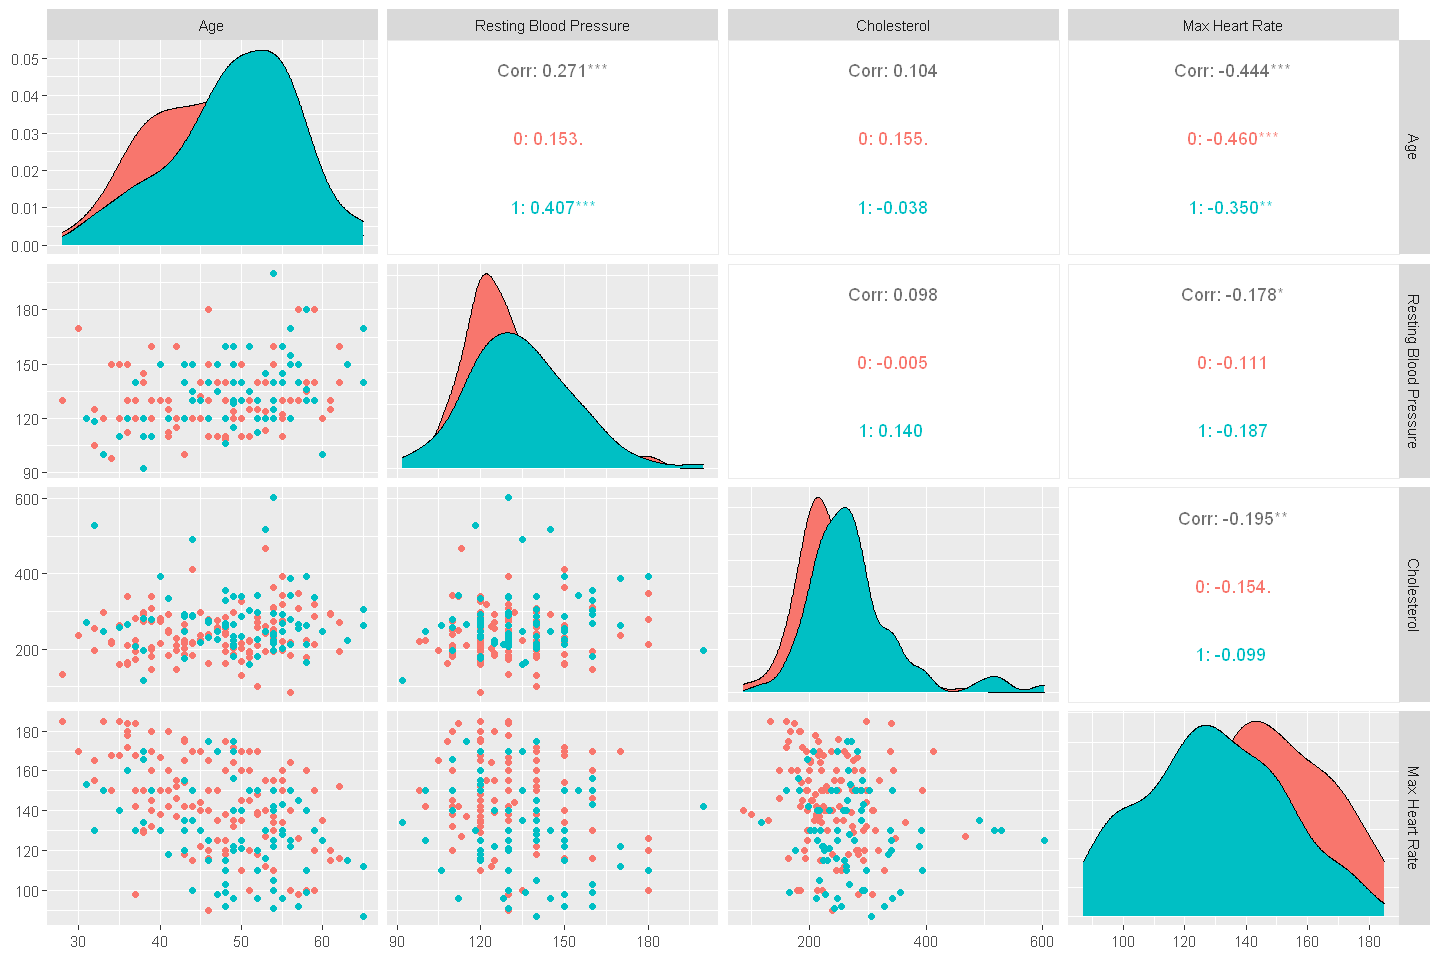

In [6]:
# Display our predictors and their correlations with one another.
library(GGally)
training_correlations <- hungarian_train |>
    ggpairs(columns = 1:4, ggplot2::aes(colour=diagnosis), 
            columnLabels = c("Age", "Resting Blood Pressure", "Cholesterol", "Max Heart Rate"))
training_correlations

Figure 2.1.5: How each predictor relates to other predictors and to the diagnosis.

Visualizing distribution of predictor variables:

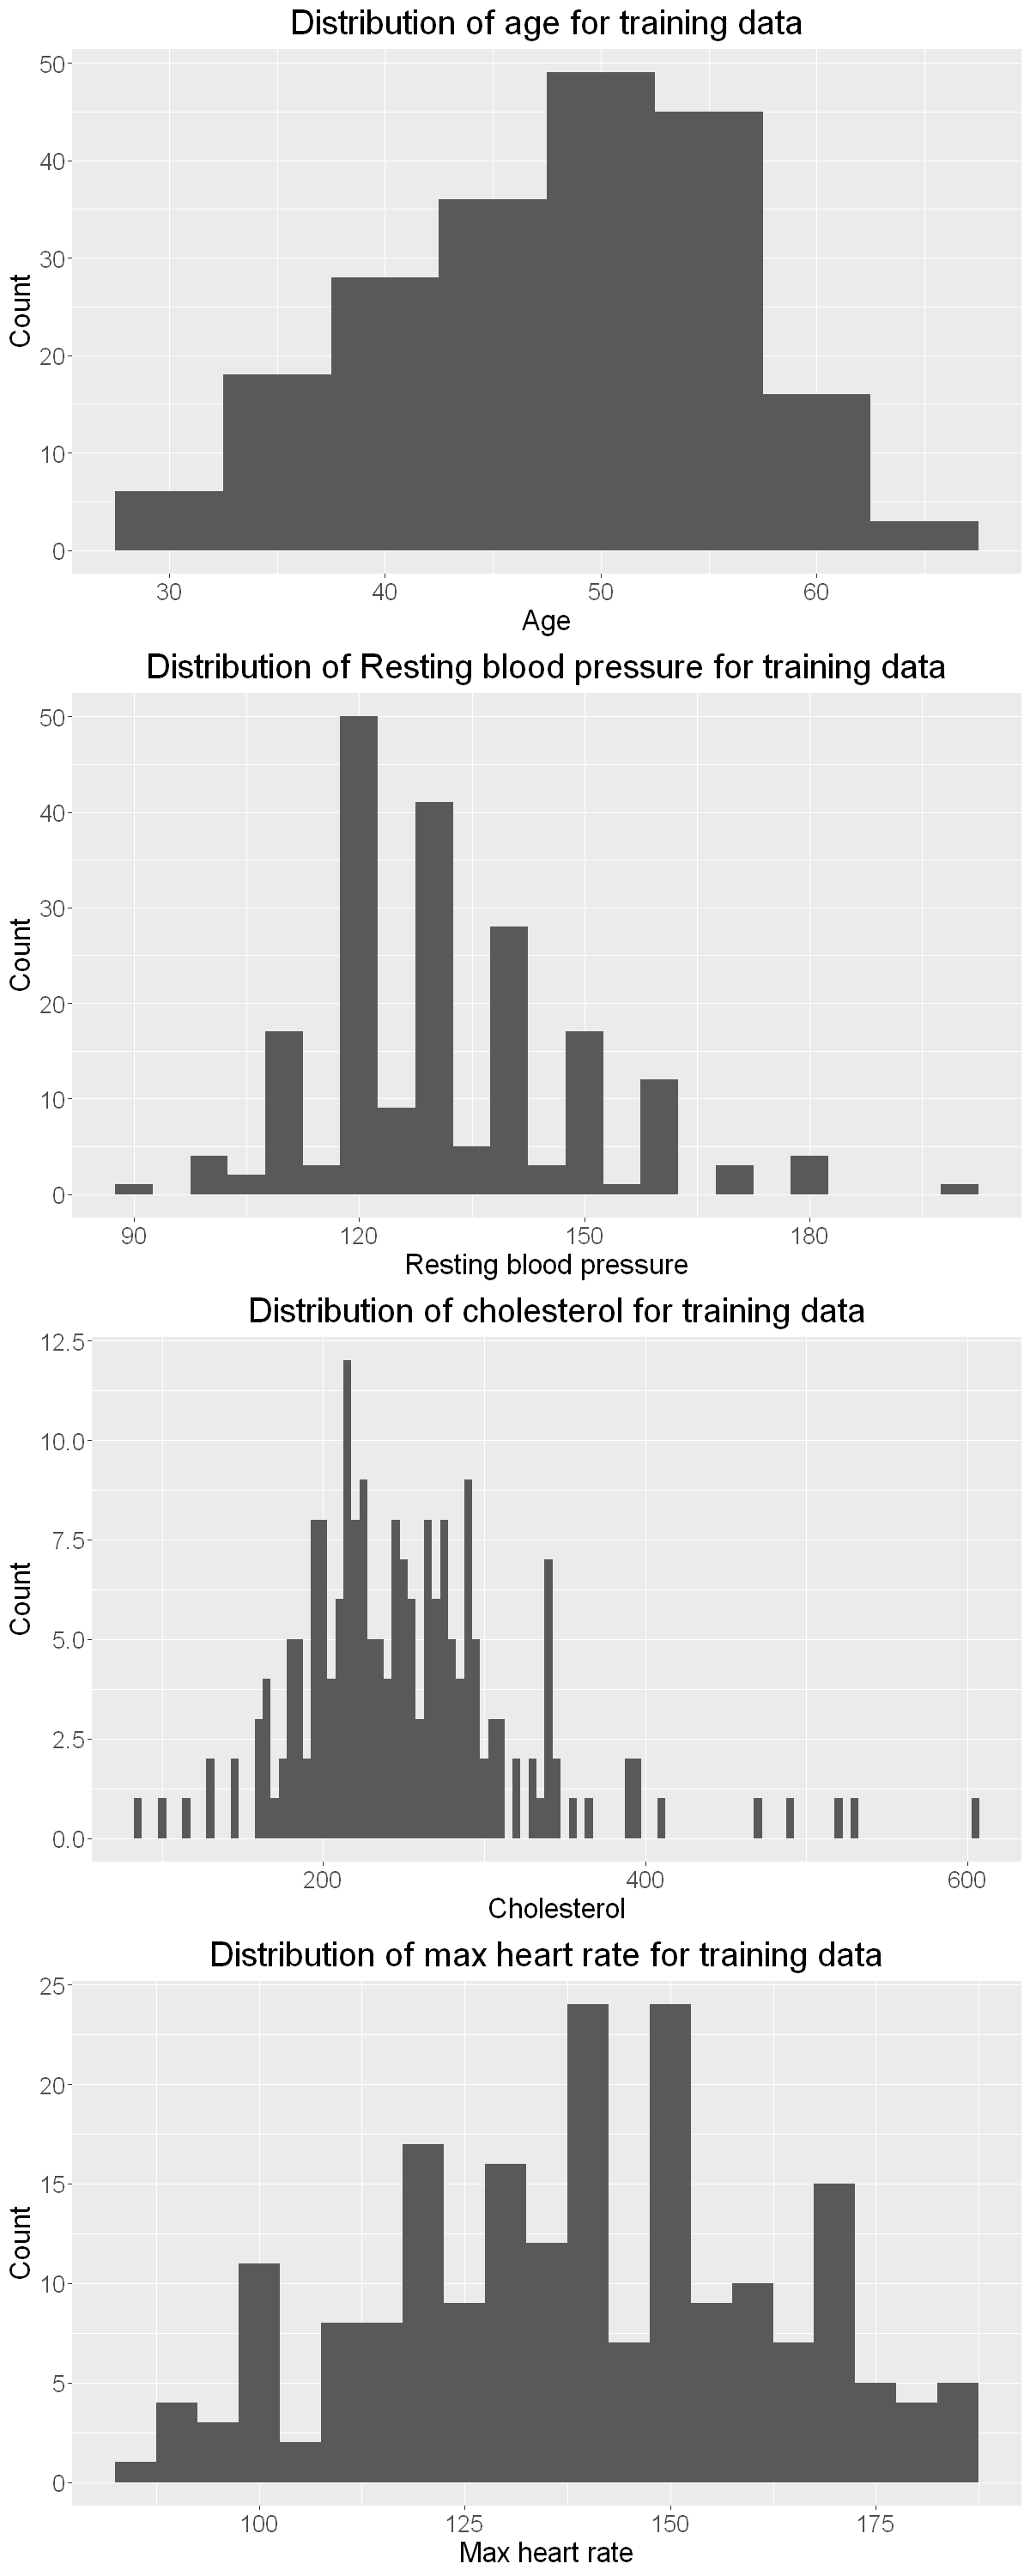

In [7]:
options(repr.plot.width = 10, repr.plot.height = 25)

training_age_plot <- hungarian_train |>
                ggplot(aes(x=age))+
                geom_histogram(binwidth=5)+
                labs(x="Age", y="Count")+
                ggtitle("Distribution of age for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_resting_blood_pressure_plot <- hungarian_train |>
                ggplot(aes(x=resting_blood_pressure))+
                geom_histogram(binwidth=5)+
                labs(x="Resting blood pressure", y="Count")+
                ggtitle("Distribution of Resting blood pressure for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_cholesterol_plot <- hungarian_train |>
                ggplot(aes(x=cholesterol))+
                geom_histogram(binwidth=5)+
                labs(x="Cholesterol", y="Count")+
                ggtitle("Distribution of cholesterol for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5))

training_max_heart_rate_plot <- hungarian_train |>
                ggplot(aes(x=max_heart_rate))+
                geom_histogram(binwidth=5)+
                labs(x="Max heart rate", y="Count")+
                ggtitle("Distribution of max heart rate for training data")+
                theme(text=element_text(size=20), plot.title=element_text(hjust=0.5)) 

hungarian_training_plot <- plot_grid(training_age_plot,
                                     training_resting_blood_pressure_plot, 
                                     training_cholesterol_plot, 
                                     training_max_heart_rate_plot,
                                     ncol=1)

hungarian_training_plot

Figure 2.1.6: Distribution of predictor variables

## 2.2: Data Analysis

In [8]:
hungarian_recipe <- recipe(diagnosis ~ age + resting_blood_pressure + cholesterol + max_heart_rate, data = hungarian_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

hungarian_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In the initialized recipe, we set the diagnosis as our target variable while setting age, resting blood pressure, cholesterol, and max heart rate to be our predictors. The predictors were then standardized(scaled and centered) to have a mean of 0 and a standard deviation of 1.

In [9]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We create the model specification here. We use the k nearest neighbor algorithm and set it to tune the neighbors. We set the engine to be k nearest neighbors and the mode to classification, as this is a k nearest neighbor classification problem. 

In [10]:
hungarian_vfold <- vfold_cv(hungarian_train, v = 5, strata = diagnosis)

Doing cross-validation in k-nearest neighbour classification will allow the best k to be picked accordingly to the accuracy that each k results in, where the k that gives the highest prediction accuracy will be chosen. 5-fold cross-validation tunes the model by splitting the overall training data into 5 even-sized groups, in which while 1 group of data is used as the validation set, the other 4 remaining groups are used as the training set. This process was then repeated 5 times (Dr. Campbell).

In [11]:
k_tibble <- tibble(neighbors = seq(from = 1, to = 31, by = 2))

In [12]:
results <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = hungarian_vfold, grid = k_tibble) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5126829,5,0.01463592,Preprocessor1_Model01
3,accuracy,binary,0.5175610,5,0.03150935,Preprocessor1_Model02
5,accuracy,binary,0.5425610,5,0.03654897,Preprocessor1_Model03
7,accuracy,binary,0.5873171,5,0.03119866,Preprocessor1_Model04
9,accuracy,binary,0.5773171,5,0.01961994,Preprocessor1_Model05
11,accuracy,binary,0.6117073,5,0.02120286,Preprocessor1_Model06
13,accuracy,binary,0.6367073,5,0.01551515,Preprocessor1_Model07
15,accuracy,binary,0.6319512,5,0.02370736,Preprocessor1_Model08
17,accuracy,binary,0.6468293,5,0.02868019,Preprocessor1_Model09


Figure 2.2.1: A table of the accuracies of each K found through cross-validation.

After combining the recipe and the model specification into a workflow and filtering the workflow to contain only our desired metric variable (accuracy), the estimated accuracy can be observed for each possible k we have previously chosen to test. 

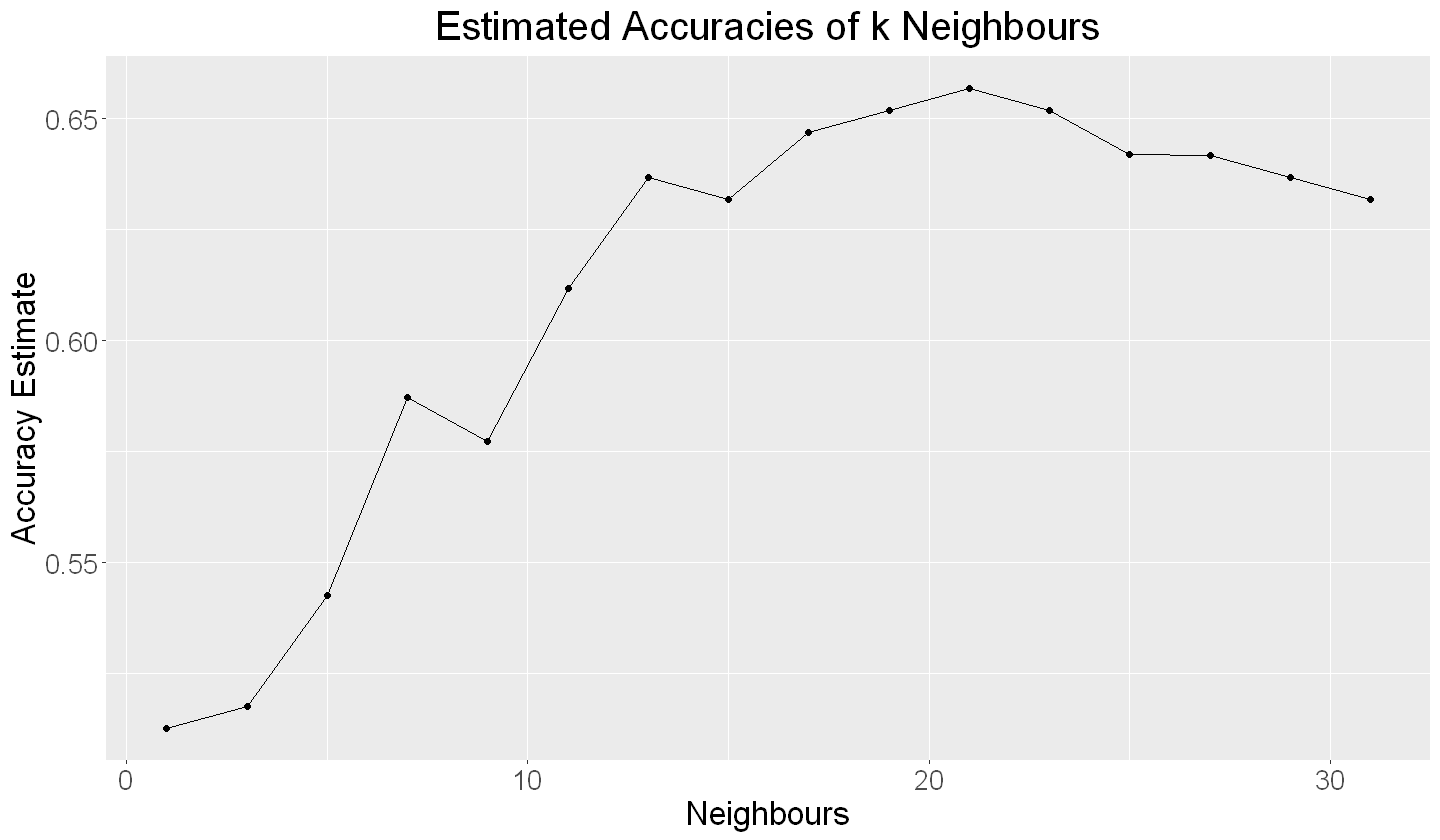

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)

cross_val_plot <- results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies of k Neighbours") +
    theme(text = element_text(size=20), plot.title = element_text(hjust=0.5))

cross_val_plot

Figure 2.2.2: An elbow plot of the accuracies of each K value found through cross-validation. From this plot, it is clear that the best K for our analysis is 21. 

Visualizing the variance of estimated accuracies of the different number of k neighbours, and observed that there is an "elbow" at 21, 22 where the accuracy stops increasing dramatically and begins to level down or start to decrease (Dr. Campbell).

In [14]:
best_k <- results |>
    filter(mean == max(mean)) |>
    pull(neighbors)

best_k

[1] 21

In order to get a more accuracy number for k, we filtered the previous workflow that stored the estimated accuracy of each of the picked k to get the k that has the maximum accuracy mean.

In [15]:
##Create nearest neighbor model with best number of k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

#Fit the model and recipe into training data
hungarian_fit <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = hungarian_train)

# Get the prediction column
hungarian_predictions <- predict(hungarian_fit, hungarian_test) |> 
    bind_cols(hungarian_test)

# Compare the accuracy of predictions to the true values in the test set
hungarian_accuracy <- hungarian_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# Compare the predictions to the true values in a confusion matrix
hungarian_comparison <- hungarian_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

hungarian_accuracy
hungarian_comparison

.metric,.estimate
<chr>,<dbl>
accuracy,0.6666667


          Truth
Prediction  0  1
         0 35 15
         1  8 11

Figure 2.2.3: Accuracy tibble and prediction of testing data matrix

## Part 3: Discussion

Overall, our model did very poorly and would not be recommended for use in any real-world setting. The overall accuracy was about 66.7%, and, more importantly, our model only accurately identified heart disease in patients 15.9% of the time. That means that our model would have incorrectly diagnosed about 84% of patients as having no heart disease. This is not good! 

These results are likely due to a few reasons: (1) our limited amount of data, (2) our predictor variables having little to no correlation with what we are trying to predict, and (3) overfitting our model to our training data. First, our dataset was very small, having only 270 total observations after filtering out observations labeled “N.A.” and before splitting the data into training and testing. Then, after doing the initial split, we had a training dataset with only 201 observations and a testing dataset with only 69 observations.

Second, our dataset showed little correlation between predictors and the prediction overall. From Figure 2.1.5, it is clear that none of our predictors have a clear correlation with whether or not someone has heart disease (based on this dataset) because the red and blue points (red equaling “no heart disease” and blue equaling “heart disease”) are not located in concise clusters in any of these experimental graphs. Due to this, our model struggles to find patterns in the data and therefore struggles to accurately classify new data. This issue is also clear when changing the initial random seed in our analysis. If the seed changes, our results vary significantly which means that our data is not well-suited for classification. 

In conclusion, we expected to find a correlation between our four risk factors and the likelihood of having heart disease, however, the accuracy is only about 66.7% and this is too low to be used practically. To develop the model more, we would require more data to be fed into the model in training so that it can have a better accuracy and thereby be a viable source of medical suggestion.

This raises some ongoing questions:
1) Would we be able to find correlations between these four risk factors and heart disease if our dataset had been larger?
2) Could one of the other heart disease datasets (such as the Cleveland set) have produced better results and a more reliable model overall?
3) Will it ever be possible to diagnose patients with a high enough degree of accuracy as to eliminate the need for a medical professional?




*************SHOULD WE STILL DISCUSS THIS??? 

From our experiment, we found that we were only able to obtain a 66% accuracy using the optimal K value of 21 that we found through cross-validation. This may be because of lack of data to train the model. Our training data had around 200 data points while our K value is 21 which is over 10% of the whole dataset. This is significantly less than the ideal number of data points required for a high accuracy model. However, we tried other K values as well and found that a K value of 12 actually gave us a higher accuracy of 74%! This likely means that we overfit our model to the training data. 

In [16]:
# Testing neighbors = 12
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_spec

hungarian_fit <- workflow() |>
  add_recipe(hungarian_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = hungarian_train)

hungarian_fit

# Get the prediction column
hungarian_predictions <- predict(hungarian_fit, hungarian_test) |> 
    bind_cols(hungarian_test)

# Compare the accuracy of predictions to the true values in the test set
hungarian_accuracy <- hungarian_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

hungarian_accuracy

# Compare the predictions to the true values in a confusion matrix
hungarian_comparison <- hungarian_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

hungarian_comparison

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 12
  weight_func = rectangular

Computational engine: kknn 


== Workflow [trained] ==================================================================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor --------------------------------------------------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model ---------------------------------------------------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(12,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3830846
Best kernel: rectangular
Best k: 12

.metric,.estimate
<chr>,<dbl>
accuracy,0.7391304


          Truth
Prediction  0  1
         0 39 14
         1  4 12

## Expected Outcomes and Significance

*********** WE SHOULD DELETE THIS SECTION

We expected to find a correlation between our four risk factors and likelihood of having heart disease. However, the accuracy is too low to be used practically. To develop the model more, we would require more data to be fed into the model to train so that it can have a better accuracy and be a viable source of medical suggestion.

Our goal of creating a model with high accuracy of heart disease prediction, if successful, can aid the medical community by creating a fast and easier diagnosis of heart disease, such as in a rural setting where equipment like ECG may not exist. They could input our measurements for each of our 4 risk factors that need minimal equipment and determine whether the patient is developing heart disease. 

Future questions:
- Is our model applicable to other regions such as longbeach?
- Is it ethical to rely only on a model and remove a doctor's role?
- Can a model be 100% accurate?
- Could these data points be used against individuals by insurance companies as a form of stigmatization? How do we protect data but publicize it for others?
- Does this model break the HIPAA law that protects a patient's medical information?

## References

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.